In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import mpmath as mp
#from mpmath import jtheta
plt.style.use('ggplot')
%matplotlib inline

#### 1. Read production data from CSV file

In [2]:
#Extract api#, monthly_oil and date from Drillinginfo File
df = pandas.read_csv('Monthly_Production.CSV')
oil = np.array(df['Monthly Oil'].values)
api_well = np.array(df['API/UWI'].values)
pro_month = np.array(df['Monthly Production Date'].values)
unique_ids=len(np.unique(api_well))
print('Total number of wells are: {}'.format (unique_ids)) # Confirming all 153 wells are read into memory

Total number of wells are: 153


#### 2. Split each individual well's production data into an array
  * Pick a well, and plot the original production data
  * Take first 12 month of log(oil rate) as training data

In [3]:
ID_0 = api_well[0]
i=0
j=0
k=0
oil_array=np.zeros((unique_ids,36),dtype=int)
for ID in api_well:
    if ID==ID_0:
        oil_array[i,j]=oil[k]
        j=j+1
    else:
        ID_0=ID
        i=i+1
        j=0
    k=k+1 

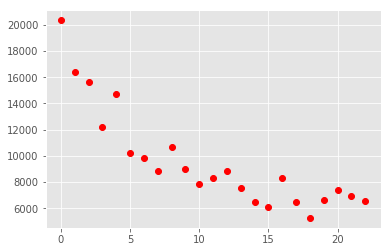

In [4]:
cur = oil_array[3]
rec_month = np.count_nonzero(cur)
plt.plot(cur[:rec_month],'ro')

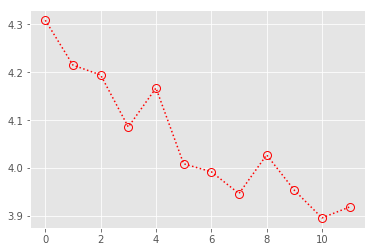

In [5]:
data = np.log10(cur[0:12])
marker_style = dict(color='r', linestyle=':', marker='o',
                    markersize=8, markerfacecoloralt='gray')
plt.plot(data,fillstyle='none',**marker_style)

#### 3. Define Arps equation and get best estimate using least square residual. Plot data, initial guess and best estimate

In [6]:
def Arps(t,Di,logQi,b):
    Qt = logQi - 1/b*np.log10(1+b*Di*t)
    return Qt

In [71]:
def Jacobi_theta(t,logQi,chi,eta):
    Qt = np.zeros(len(t))
    for i in range(len(t)):
        Qt[i] = logQi + np.log10(float(mp.jtheta(2,chi,np.exp(-eta*t[i]))))
    return Qt

In [61]:
#t = mp.arange(12)
logQi = 4
chi = 0.5
eta = 0.5
t_fine = np.linspace(0.1,11,119)
t = np.linspace(1,11,12)

In [11]:
Jacobi_theta(t,logQi,chi,eta)-data

array([-0.12675037, -0.07044787, -0.10118515, -0.04304908, -0.17426529,
       -0.06565867, -0.09848878, -0.10230236, -0.23240802, -0.20803463,
       -0.19956892, -0.27186211])

In [13]:
y_init =  Jacobi_theta(t_fine,logQi,chi,eta)
params, params_covariance = optimize.curve_fit(Arps, t, data,
                                               p0=[0.22,4.3,2])
y_hat = Arps(t,params[0],params[1],params[2])
sigma = np.sqrt(np.sum(np.power(data-y_hat,2))/(len(data)-3))

print('The best estimate are: \n D = {}\n log(Qi) = {}\n b = {}'.format(params[0],params[1],params[2]))
print('Variance is {}'.format(sigma))

The best estimate are: 
 D = 0.3770324970044109
 log(Qi) = 4.432657241417277
 b = 1.7332770370141504
Variance is 0.04497326280262359


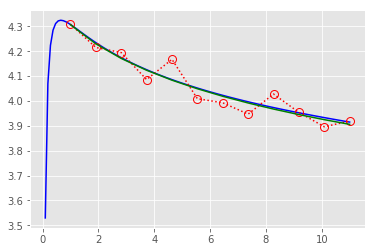

In [84]:
y_init =  Jacobi_theta(t_fine,logQi,chi,eta)
plt.plot(t_fine,y_init,'b-') # initial guess
plt.plot(t, data,fillstyle='none',**marker_style)
plt.plot(t, y_hat,'g-')

#### 4. MCMC for parameter estimation
  * Define posterior function
  * Initialize the chain
  * Sampling from posterior distribution

In [17]:
def post(logQi,chi,eta,sigma,t,data):
    like = np.prod(np.exp(-np.power(Jacobi_theta(t,logQi,chi,eta)-data, 2)/sigma**2))
    return like # because constant uniform prior

In [62]:
logQi = data[0]
Niter = 100000
chain = np.zeros((Niter,3))
chain[0,0] = logQi# Initialize the chain with first guess
chain[0,1] = chi
chain[0,2] = eta

In [64]:
np.exp(-eta*t)

array([0.81161329, 0.671335  , 0.55530224, 0.45932445, 0.37993535,
       0.31426777, 0.25995009, 0.21502062, 0.17785671, 0.14711616,
       0.12168878, 0.10065623])

In [72]:
for ii in np.arange(Niter-1):
        if ii%10000 ==0:
            print('iteration {}'.format(ii))
        logQi    = chain[ii,0] 
        chi      = chain[ii,1] 
        eta      = chain[ii,2] 
        chi_p    = float(chi + np.random.normal(loc=0.0,scale=0.1,size=1))
        logQi_p  = float(logQi + np.random.normal(loc=0.0,scale=0.1,size=1))
        eta_p     = float(eta + np.random.normal(loc=0.0,scale=0.1,size=1))
        
        if chi_p < 0 or eta_p<0 or logQi_p > 7 or logQi_p< -2:
            chain[ii+1,:] = chain[ii,:]
        elif (post(logQi_p,chi_p,eta_p,sigma,t,data) / post(logQi,chi,eta,sigma,t,data)) > np.random.uniform():
            chain[ii+1,0] = logQi_p 
            chain[ii+1,1] = chi_p 
            chain[ii+1,2] = eta_p 
        else:
            chain[ii+1,:] = chain[ii,:]
print('Sampling finished at iteration {}'.format(Niter)) 

iteration 0


/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


iteration 10000


/Users/weibing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


iteration 20000
iteration 30000
iteration 40000
iteration 50000
iteration 60000
iteration 70000


KeyboardInterrupt: 

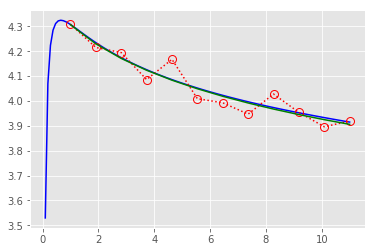

In [86]:
y_theta =  Jacobi_theta(t_fine,logQi,chi,eta)
plt.plot(t_fine,y_theta,'b-')
plt.plot(t,data,'ro',fillstyle='none',**marker_style)
plt.plot(t,y_hat,'g-')

(100000, 3)

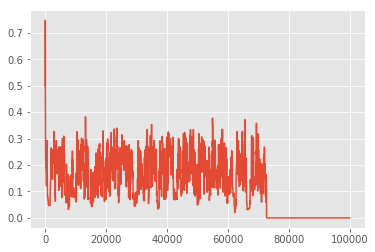

In [76]:
plt.plot(chain[:,2])
chain.shape

In [70]:
chain[0:10,1]

array([0.5       , 0.5       , 0.70351153, 0.70351153, 0.70351153,
       0.82625184, 0.82625184, 0.82625184, 0.82625184, 0.82625184])

In [15]:
a = np.array(jtheta(2,0.5,0.5))
print(type(a),a)

<class 'numpy.ndarray'> 1.48421608765958
